In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
from pprint import pprint
import seaborn as sns
from api_keys import weather_api_key


file = "Resources/kaggle_income.csv"

df_main = pd.read_csv(file)

# Limit the dataset to mainland USA (Lat 25 ~ 50, Lon -66 ~ -126)
df_main = df_main[(df_main["Lat"] > 25) & (df_main["Lat"] < 50) & (df_main["Lon"] > -126) & (df_main["Lon"] < 66)]

# Add new columnes for "Number of Households", "Population Density", and "Percentage of Water Area"
df_main["Number of Households"] = df_main["sum_w"] / df_main["Mean"]
df_main["Pop density"] = round(df_main["Number of Households"] / (df_main["ALand"] + df_main["AWater"]) *100000000000000,0)
df_main["Water%"] = df_main["AWater"] / (df_main["ALand"] + df_main["AWater"]) * 100


# Function to return dataframe optimized for plotting - Use when you want to plot using values outside df_main (ex : API)
def PlotvsIncome(df1,df2,para,interval):

    merge_table = pd.merge(df1, df2, on="City", how="right")
    temp_bin =[] 
    bin_name = []

    for n in np.arange(min(merge_table[para]),max(merge_table[para]),interval):
        temp_bin.append(n)

    bin_name = temp_bin[1:]

    merge_table[para + "'"] = pd.cut(merge_table[para], temp_bin, labels = bin_name)
    df_plot = merge_table.groupby([para]).sum()
    df_plot["Mean Household Income"] = df_plot["sum_w"] / df_plot["Number of Households"]
    df_plot = df_plot["Mean Household Income"]

    return df_plot

# Function to return dataframe optimized for plotting - Use when you want to plot using only the values inside df_main
def PlotvsIncome_self(df,para,interval):

    temp_bin =[] 
    bin_name = []

    for n in np.arange(min(df[para]),max(df[para]),interval):
        temp_bin.append(n)

    bin_name = temp_bin[1:]

    df[para+"'"] = pd.cut(df[para], temp_bin, labels = bin_name)
    df_plot = df.groupby([para+"'"]).sum()
    df_plot["Mean Household Income"] = df_plot["sum_w"] / df_plot["Number of Households"]
    df_plot = df_plot.reset_index()
    df_plot[para+"'"] = df_plot[para+"'"].astype(int)
    df_plot = df_plot.dropna(how='any')
    
    return df_plot, para+"'"

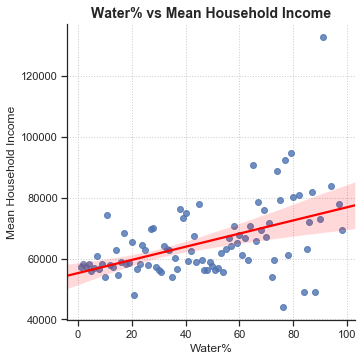

slope: 216.510565    intercept: 55214.257691
r: 0.473484     p: 0.000002     standard error: 42.693082


In [8]:

#Input what you want to compare against and Interval Here !!!
#-----------------------------------------
Parameter = "Water%"
Interval = 1
#-----------------------------------------

# Code for plotting itself using returned DataFrame from pre-defined funtion 
df_plot, para = PlotvsIncome_self(df_main,Parameter, Interval )

sns.set(style ="ticks",color_codes=True)
p = sns.pairplot(x_vars=para,y_vars="Mean Household Income", data = df_plot.reset_index(), kind="reg", plot_kws={"line_kws":{"color":"red"}}, height = 5)

plt.title('{} vs Mean Household Income'.format(Parameter),fontsize=14,fontweight='bold')
plt.xlabel('{}'.format(Parameter),fontsize=12)
plt.ylabel('Mean Household Income',fontsize=12)
plt.grid(linestyle='dotted')
plt.savefig('{}_vs_MHI.png'.format(Parameter))

plt.show()

# Regression line Stats

x = df_plot[para]
y = df_plot["Mean Household Income"]

slope, intercept, r_value, p_value, std_err = linregress(x, y)
print("slope: %f    intercept: %f" % (slope, intercept))
print("r: %f     p: %f     standard error: %f" % (r_value, p_value, std_err))
    

In [27]:
sns.set(style ="ticks",color_codes=True)
p = sns.pairplot(x_vars=para +"'",y_vars="Mean Household Income", data = df_main.reset_index(), kind="reg", plot_kws={"line_kws":{"color":"red"}}, height = 5)

plt.show()

NameError: name 'para' is not defined

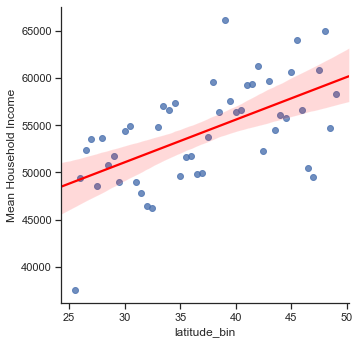

In [32]:
# Plot 1 : latitude vs Mean Income
df_main2 = df_main.groupby(["latitude_bin"]).sum()
df_main2["Mean Household Income"] = df_main2["sum_w"] / df_main2["Number of Households"]
df_main2 = df_main2["Mean Household Income"]


sns.set(style ="ticks",color_codes=True)
p = sns.pairplot(x_vars="latitude_bin",y_vars="Mean Household Income", data = df_main2.reset_index(), kind="reg", plot_kws={"line_kws":{"color":"red"}}, height = 5)

plt.show()

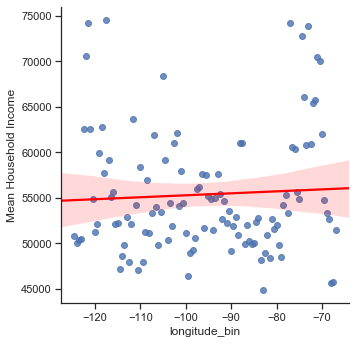

In [11]:

# Plot 2 : longitude vs Mean Income
df_main2 = df_main.groupby(["longitude_bin"]).sum()
df_main2["Mean Household Income"] = df_main2["sum_w"] / df_main2["Number of Households"]
df_main2 = df_main2["Mean Household Income"]

sns.set(style ="ticks",color_codes=True)
p = sns.pairplot(x_vars="longitude_bin",y_vars="Mean Household Income", data = df_main2.reset_index(), kind="reg", plot_kws={"line_kws":{"color":"red"}}, height = 5)

plt.show()

In [37]:
url = "http://api.openweathermap.org/data/2.5/weather?"

df_weather = pd.DataFrame(columns = ["City","Feels Like Temp(F)","Humidity(%)","Pressure(hPa)"])


cities=[]

cities_rand_num = np.random.randint(low=0, high=len(df_main["City"]), size=3000)


for n in cities_rand_num:
    try:
        cities.append(df_main["City"][n])
    except:
        next

cities
        
count = 0
for city in cities:
    try:
        print("Processing City {}".format(count))
        query_url = url + "appid=" + weather_api_key + "&q=" + city
        weather_response = requests.get(query_url)
        weather_json = weather_response.json()
        temp = round((int(weather_json["main"]["feels_like"]) - 273.15) * 9/5 + 32,2)
        humidity = weather_json["main"]["humidity"]
        pressure = weather_json["main"]["pressure"]

        new_row = []
        new_row.append(city)
        new_row.append(temp)
        new_row.append(humidity)
        new_row.append(pressure)
        df_weather.loc[count] = new_row
        count = count + 1
    except:
        print("Encountered Error, Skipping...")

Processing City 0
Processing City 1
Processing City 2
Processing City 3
Processing City 4
Processing City 5
Processing City 6
Processing City 7
Processing City 8
Processing City 9
Processing City 10
Processing City 11
Processing City 12
Processing City 13
Processing City 14
Processing City 15
Processing City 16
Processing City 17
Processing City 18
Processing City 19
Processing City 20
Processing City 21
Processing City 22
Processing City 23
Processing City 24
Processing City 25
Processing City 26
Encountered Error, Skipping...
Processing City 26
Processing City 27
Processing City 28
Processing City 29
Processing City 30
Processing City 31
Processing City 32
Processing City 33
Processing City 34
Processing City 35
Processing City 36
Processing City 37
Processing City 38
Processing City 39
Processing City 40
Processing City 41
Processing City 42
Processing City 43
Processing City 44
Processing City 45
Processing City 46
Processing City 47
Processing City 48
Processing City 49
Processing

In [9]:
merge_table = pd.merge(df_main, df_weather, on="City", how="right")
merge_table.to_csv("incomemergedwithweather.csv", index=False, header=True)

NameError: name 'df_weather' is not defined

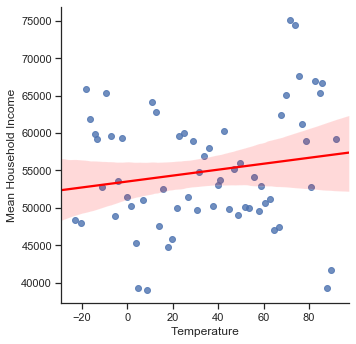

In [35]:

PlotvsIncome(df_main,df_weather,"Feels Like Temp(F)",1)

# Temp_bin = []
# Temp_bin_name = []

# for n in np.arange(min(merge_table["Feels Like Temp(F)"]),max(merge_table["Feels Like Temp(F)"]),1):
#     Temp_bin.append(n)
    
# Temp_bin_name = Temp_bin[1:]

# merge_table["Temperature"] = pd.cut(merge_table["Feels Like Temp(F)"], Temp_bin, labels = Temp_bin_name)
# df_main3 = merge_table.groupby(['Temperature']).sum()
# df_main3["Mean Household Income"] = df_main3["sum_w"] / df_main3["Number of Households"]
# df_main3 = df_main3["Mean Household Income"]

# sns.set(style ="ticks",color_codes=True)
# p = sns.pairplot(x_vars="Temperature",y_vars="Mean Household Income", data = df_main3.reset_index(), kind="reg", plot_kws={"line_kws":{"color":"red"}}, height = 5)

# plt.show()

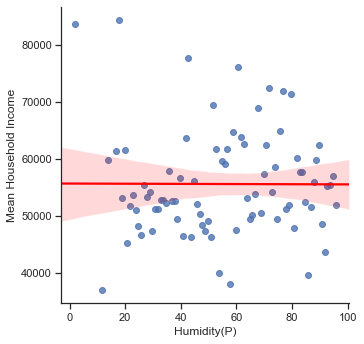

In [36]:
Humid_bin = []
Humid_bin_name = []

for n in np.arange(min(merge_table["Humidity(%)"]),max(merge_table["Humidity(%)"]),1):
    Humid_bin.append(n)
    
Humid_bin_name = Temp_bin[1:]

merge_table["Humidity(P)"] = pd.cut(merge_table["Humidity(%)"], Temp_bin, labels = Temp_bin_name)
df_main3 = merge_table.groupby(['Humidity(P)']).sum()
df_main3["Mean Household Income"] = df_main3["sum_w"] / df_main3["Number of Households"]
df_main3 = df_main3["Mean Household Income"]

sns.set(style ="ticks",color_codes=True)
p = sns.pairplot(x_vars="Humidity(P)",y_vars="Mean Household Income", data = df_main3.reset_index(), kind="reg", plot_kws={"line_kws":{"color":"red"}}, height = 5)

plt.show()

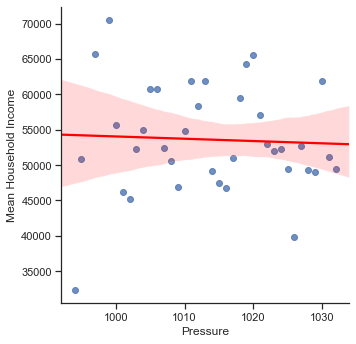

In [39]:
Press_bin = []
Press_bin_name = []

for n in np.arange(min(merge_table["Pressure(hPa)"]),max(merge_table["Pressure(hPa)"]),0.1):
    Press_bin.append(n)
    
Press_bin_name = Press_bin[1:]

merge_table["Pressure"] = pd.cut(merge_table["Pressure(hPa)"], Press_bin, labels = Press_bin_name)
df_main3 = merge_table.groupby(['Pressure']).sum()
df_main3["Mean Household Income"] = df_main3["sum_w"] / df_main3["Number of Households"]
df_main3 = df_main3["Mean Household Income"]

sns.set(style ="ticks",color_codes=True)
p = sns.pairplot(x_vars="Pressure",y_vars="Mean Household Income", data = df_main3.reset_index(), kind="reg", plot_kws={"line_kws":{"color":"red"}}, height = 5)

plt.show()

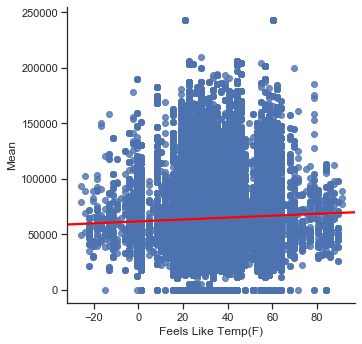

In [6]:
df_chart = pd.read_csv("incomemergedwithweather.csv")

p = sns.pairplot(x_vars="Feels Like Temp(F)",y_vars="Mean", data = df_chart, kind="reg", plot_kws={"line_kws":{"color":"red"}}, height = 5)
plt.show()

In [9]:
df_chart.info()

# p = sns.pairplot(x_vars="Humidity(",y_vars="Mean", data = df_chart, kind="reg", plot_kws={"line_kws":{"color":"red"}}, height = 5)
# plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132436 entries, 0 to 132435
Data columns (total 26 columns):
id                      132436 non-null int64
State_Code              132436 non-null int64
State_Name              132436 non-null object
State_ab                132436 non-null object
County                  132436 non-null object
City                    132436 non-null object
Place                   132436 non-null object
Type                    132436 non-null object
Primary                 132436 non-null object
Zip_Code                132436 non-null int64
Area_Code               132436 non-null object
ALand                   132436 non-null int64
AWater                  132436 non-null int64
Lat                     132436 non-null float64
Lon                     132436 non-null float64
Mean                    132436 non-null int64
Median                  132436 non-null int64
Stdev                   132436 non-null int64
sum_w                   132436 non-null float64
N

In [ ]:
def PlotvsIncome(df1,df2,para,interval):

merge_table = pd.merge(df1, df2, on="City", how="right")
temp_bin =[] 
bin_name = []

for n in np.arange(min(merge_table[para]),max(merge_table[para]),interval):
    temp_bin.append(n)

bin_name = temp_bin[1:]

merge_table[para + "'"] = pd.cut(merge_table[para], temp_bin, labels = bin_name)
df_plot = merge_table.groupby([para]).sum()
df_plot["Mean Household Income"] = df_plot["sum_w"] / df_plot["Number of Households"]
df_plot = df_plot["Mean Household Income"]

sns.set(style ="ticks",color_codes=True)
p = sns.pairplot(x_vars=para +"'",y_vars="Mean Household Income", data = df_main3.reset_index(), kind="reg", plot_kws={"line_kws":{"color":"red"}}, height = 5)

plt.show()

return df_plot
